In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker  # Added for axis control
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import confusion_matrix
import seaborn as sns
import os
import sys

# Add path to src
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '.')))
from src.quantum_model import QuantumRiskModel

In [26]:
# 1. CONFIGURATION
TARGET_TICKER = "AAPL"
N_COMPONENTS = 8
DAYS_TO_PLOT = 150

# 2. LOAD MODEL
weights_path = "data/quantum_weights.npy"
if not os.path.exists(weights_path):
    raise FileNotFoundError("Model weights not found!")

payload = np.load(weights_path, allow_pickle=True).item()
trained_weights = payload['weights']
trained_bias = payload['bias']

print("✅ Weights loaded successfully.")

✅ Weights loaded successfully.


In [27]:
q_model = QuantumRiskModel(n_qubits=N_COMPONENTS, n_layers=3)

# 3. DATA PROCESSING
df = pd.read_csv('data/final_ml_dataset.csv')
drop_cols = ['TARGET_Risk_Level', 'Date', 'Ticker', 'TARGET_Future_Vol']
feature_cols = [c for c in df.columns if c not in drop_cols]

split_idx = int(len(df) * 0.85)
train_df = df.iloc[:split_idx]

scaler = StandardScaler()
pca = PCA(n_components=N_COMPONENTS)
minmax = MinMaxScaler(feature_range=(0, np.pi))

X_train_raw = train_df[feature_cols].values
X_train_scaled = scaler.fit_transform(X_train_raw)
X_train_pca = pca.fit_transform(X_train_scaled)
minmax.fit(X_train_pca)

# 4. PREPARE TICKER DATA
ticker_full_data = df[df['Ticker'] == TARGET_TICKER].copy()
ticker_plot_data = ticker_full_data.tail(DAYS_TO_PLOT)

X_ticker_raw = ticker_plot_data[feature_cols].values
X_ticker_scaled = scaler.transform(X_ticker_raw)
X_ticker_pca = pca.transform(X_ticker_scaled)
X_ticker_final = minmax.transform(X_ticker_pca)

y_actual = ticker_plot_data['TARGET_Risk_Level'].values
dates = ticker_plot_data['Date'].values

# 5. PREDICTION
print(f"Generating predictions for {TARGET_TICKER}...")
q_preds = []
for x in X_ticker_final:
    pred = q_model.predict(trained_weights, trained_bias, x)
    q_preds.append(int(pred))

Generating predictions for AAPL...


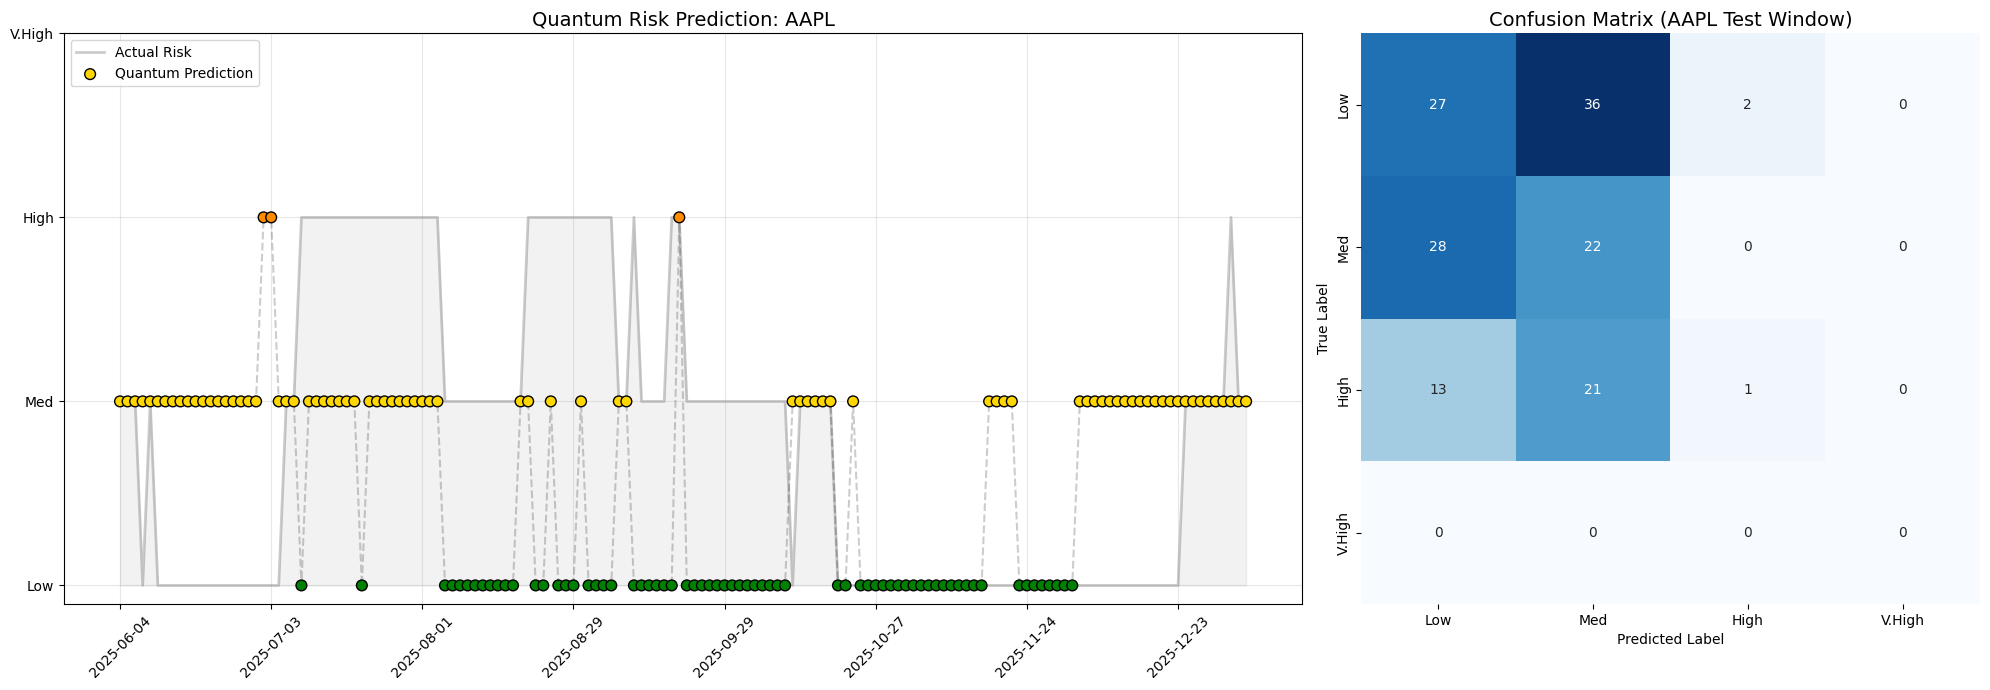

In [28]:
# 6. VISUALIZATION
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 7), gridspec_kw={'width_ratios': [2, 1]})

# --- LEFT: TIME SERIES PLOT (Fixed X-Axis Labels) ---
ax1.plot(dates, y_actual, color='gray', alpha=0.4, linewidth=2, label='Actual Risk')
ax1.fill_between(dates, y_actual, color='gray', alpha=0.1)

colors = ['green', 'gold', 'darkorange', 'crimson']
risk_labels = ['Low', 'Med', 'High', 'V.High']
pred_colors = [colors[p] for p in q_preds]

ax1.scatter(dates, q_preds, c=pred_colors, s=60, edgecolors='black', label='Quantum Prediction', zorder=10)
ax1.plot(dates, q_preds, color='black', linestyle='--', alpha=0.2)

ax1.set_title(f'Quantum Risk Prediction: {TARGET_TICKER}', fontsize=14)
ax1.set_yticks([0, 1, 2, 3])
ax1.set_yticklabels(risk_labels)

# MODIFICATION HERE: Limit the number of labels to ~10 items
ax1.xaxis.set_major_locator(ticker.MaxNLocator(nbins=10))

ax1.tick_params(axis='x', rotation=45)
ax1.legend(loc='upper left')
ax1.grid(True, alpha=0.3)

# --- RIGHT: CONFUSION MATRIX ---

cm = confusion_matrix(y_actual, q_preds, labels=[0, 1, 2, 3])
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax2,
            xticklabels=risk_labels, yticklabels=risk_labels, cbar=False)

ax2.set_title(f'Confusion Matrix ({TARGET_TICKER} Test Window)', fontsize=14)
ax2.set_xlabel('Predicted Label')
ax2.set_ylabel('True Label')

plt.tight_layout()
plt.show()